# Восстановление золота из руды

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Как золото получают из руды? Изучите внимательно стадии процесса.
Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.
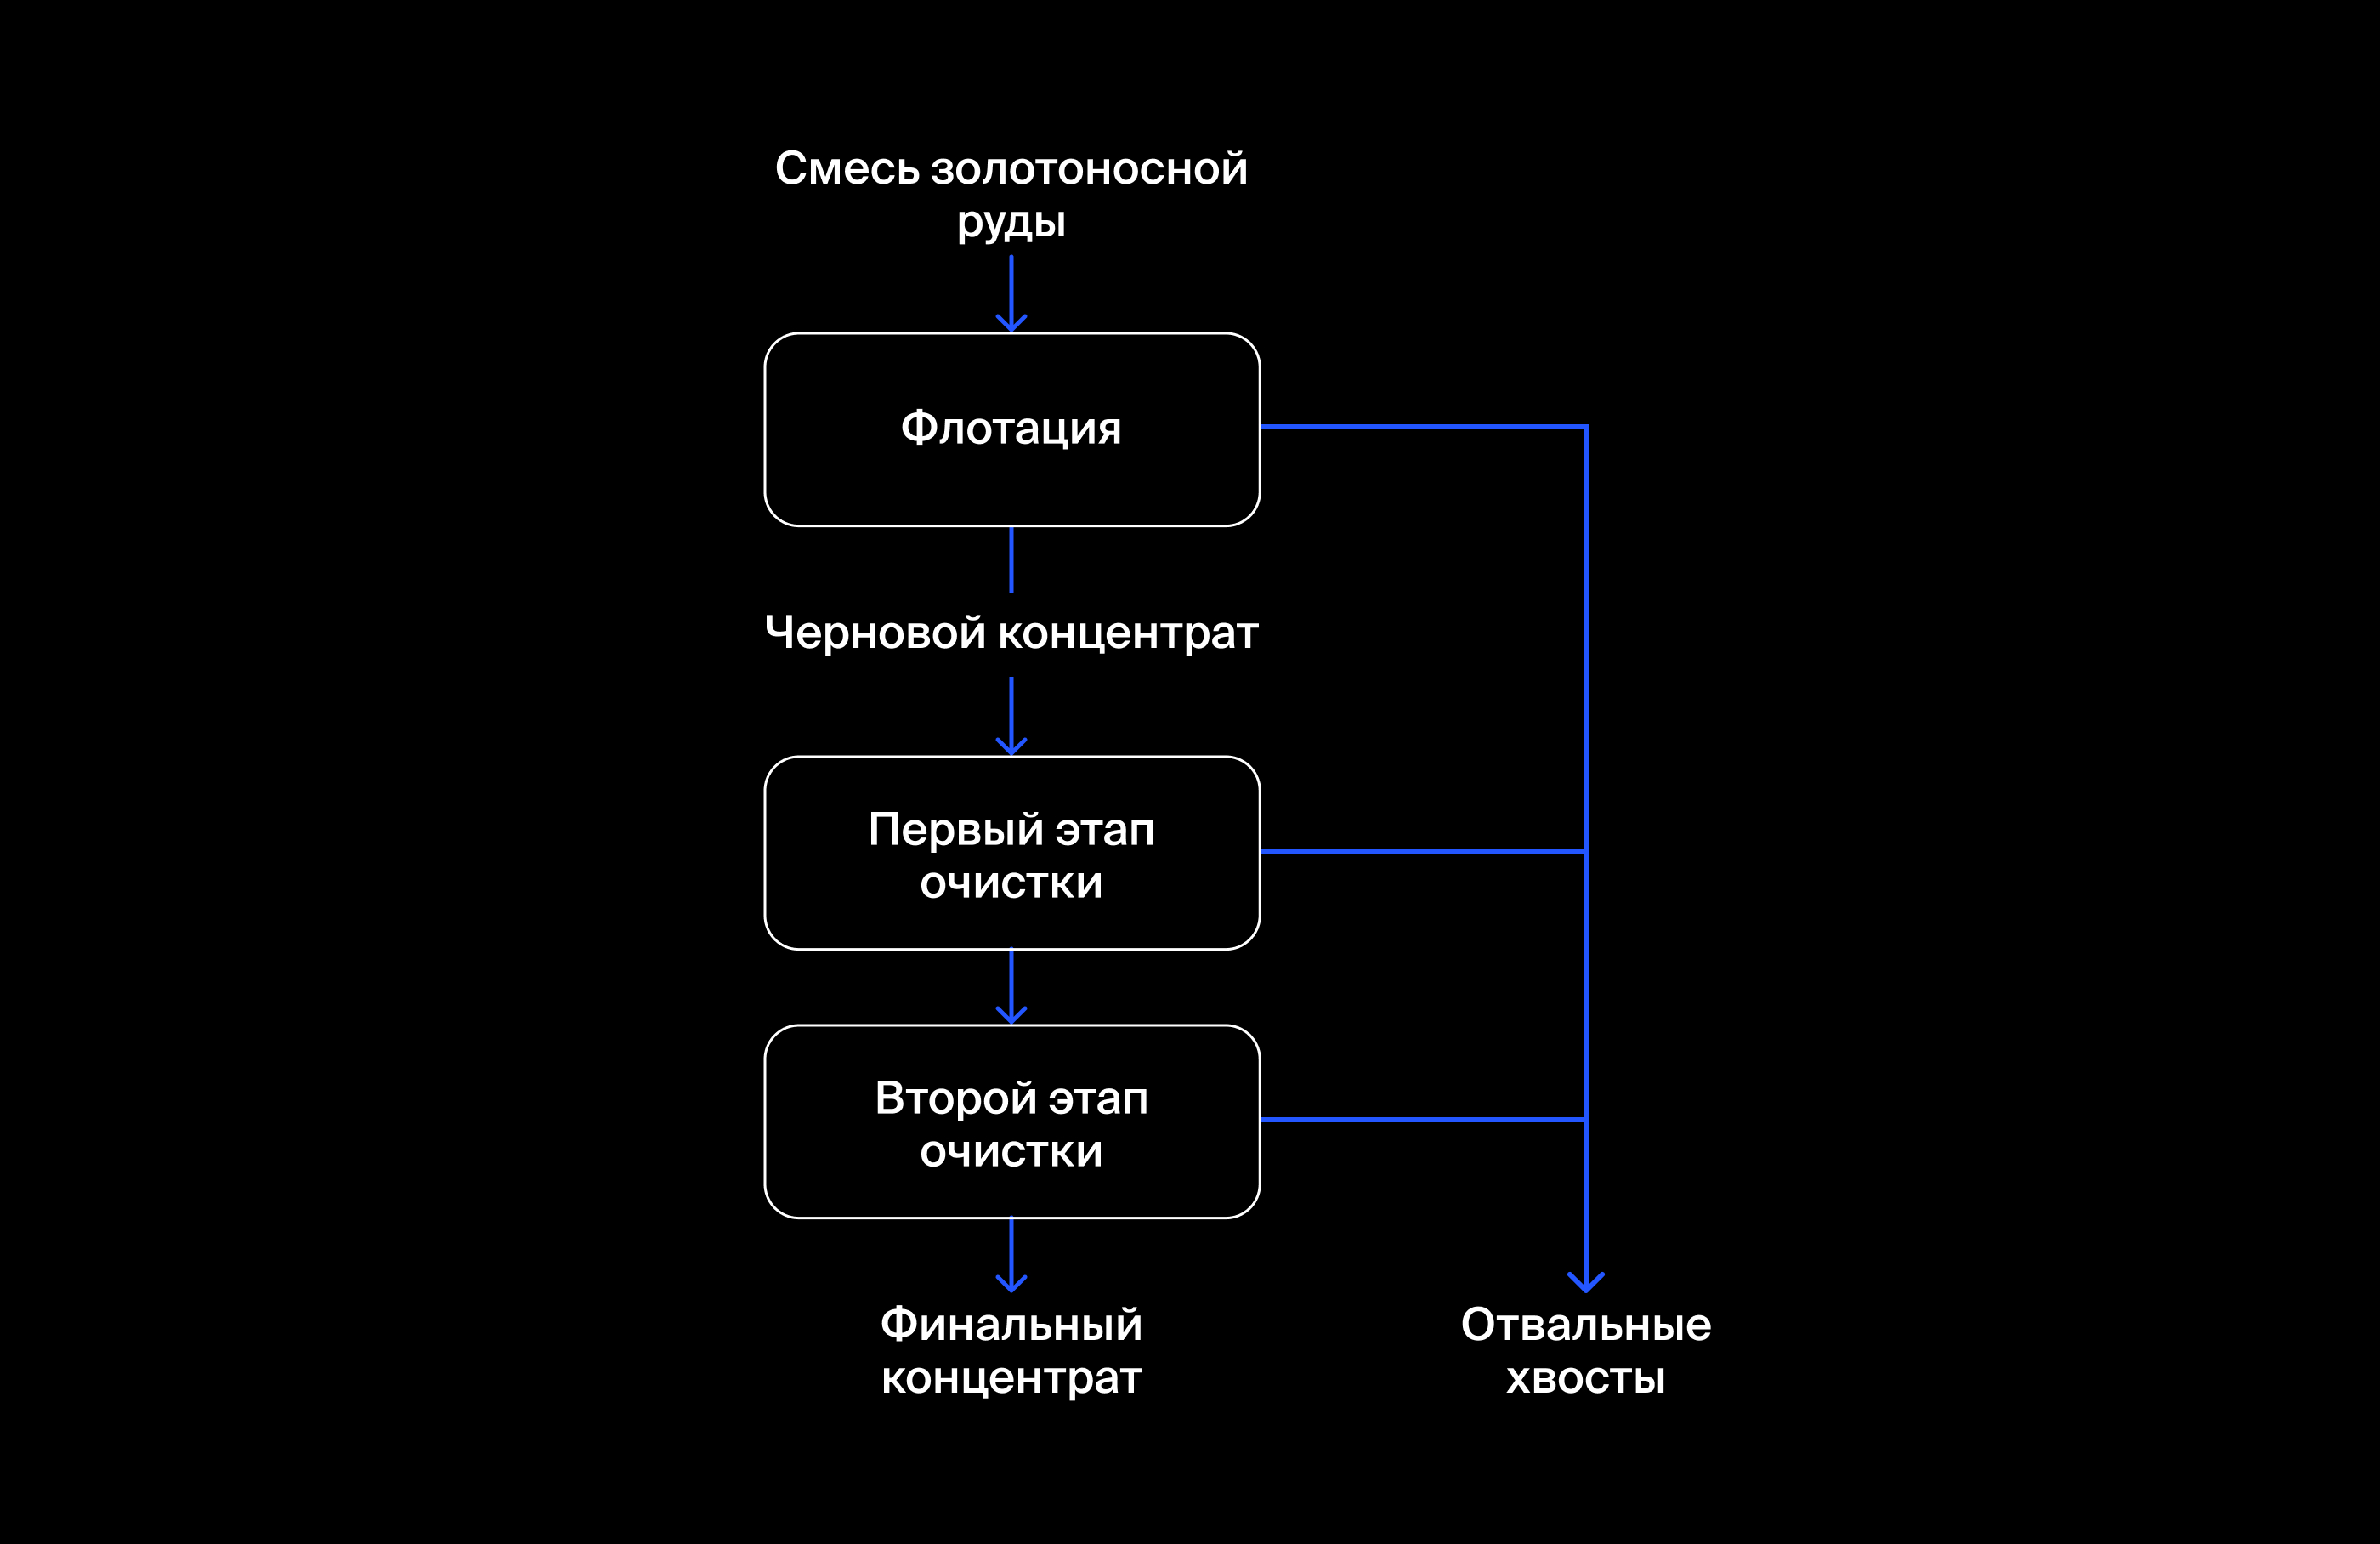
Опишем каждую стадию:
1. Флотация  
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка  
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.


**Расчёт эффективности**  
Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды. 
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.  
Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных.
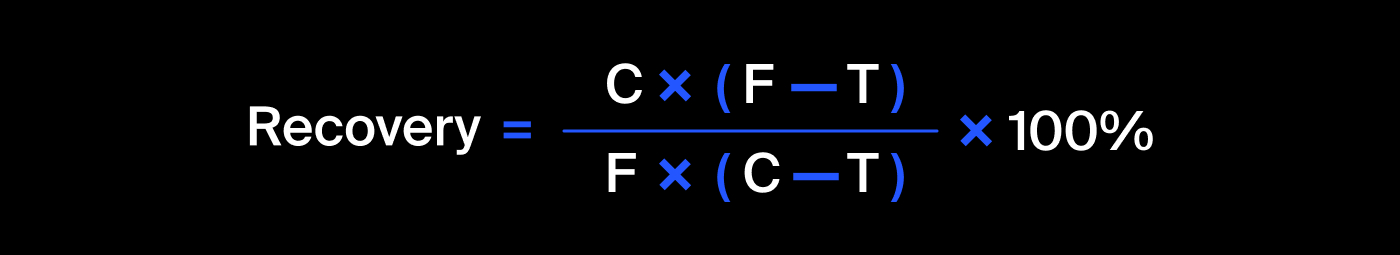

**Описание данных**
1. Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, - Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота
2. Параметры этапов 
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи


**Наименование признаков**  
Наименование признаков должно быть такое:  
`[этап].[тип_параметра].[название_параметра]`

Пример: rougher.input.feed_ag

Возможные значения для блока `[этап]`:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
!pip install catboost --quiet
import catboost as cb
from catboost import CatBoostRegressor
!pip install optuna --quiet
import optuna
import warnings
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')

In [ ]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [ ]:
df_train.shape

(14149, 87)

In [ ]:
df_train.isna().sum().sort_values(ascending=False)

secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
                                            ... 
rougher.output.concentrate_pb                  0
rougher.output.concentrate_au                  0
rougher.output.recovery                        0
rougher.output.tail_pb                         0
date                                           0
Length: 87, dtype: int64

Таблица обучающей выборки имеет 87 столбцов и 14149 строк.
В таблице содержаться пропуски.

In [ ]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [ ]:
df_test.shape

(5290, 53)

In [ ]:
df_test.isna().sum().sort_values(ascending=False)

rougher.input.floatbank11_xanthate            25
rougher.input.feed_sol                        21
secondary_cleaner.state.floatbank3_a_air       9
rougher.input.floatbank11_sulfate              8
primary_cleaner.input.depressant               5
rougher.input.floatbank10_sulfate              5
primary_cleaner.input.xanthate                 4
primary_cleaner.input.sulfate                  4
rougher.input.feed_rate                        3
secondary_cleaner.state.floatbank2_a_air       3
secondary_cleaner.state.floatbank2_b_air       2
rougher.input.feed_size                        1
secondary_cleaner.state.floatbank2_b_level     0
rougher.state.floatbank10_f_level              0
rougher.state.floatbank10_f_air                0
secondary_cleaner.state.floatbank3_a_level     0
secondary_cleaner.state.floatbank2_a_level     0
date                                           0
rougher.state.floatbank10_e_air                0
secondary_cleaner.state.floatbank3_b_air       0
secondary_cleaner.st

Таблица тестовой выборки имеет 53 столбца и 5290 строк. В таблице содержаться пропуски, однако их гораздо меньше, чем в обучающей выборке. Может заметить, что в тестовых данных значительно меньше признаков.

In [ ]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [ ]:
df_full.shape

(19439, 87)

In [ ]:
df_full.isna().sum().sort_values(ascending=False)

secondary_cleaner.output.tail_sol           1748
rougher.input.floatbank11_xanthate           453
rougher.state.floatbank10_e_air              436
primary_cleaner.output.concentrate_sol       370
secondary_cleaner.state.floatbank2_a_air     220
                                            ... 
rougher.state.floatbank10_d_level              0
rougher.state.floatbank10_d_air                0
rougher.output.tail_pb                         0
rougher.output.tail_sol                        0
date                                           0
Length: 87, dtype: int64

Таблица исходных данных имеет 87 столбцов и 19439 строк, что равняется сумме строк обучающей и тестовой выборок. В таблице также содержиться большое количество пропусков.  
Заполнение пропусков в пункте "Предобработка данных".

### Проверка рассчетов эффективности обогащения

In [ ]:
df_train.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [ ]:
recovery = (df_train['rougher.output.concentrate_au']*(df_train['rougher.input.feed_au']-df_train['rougher.output.tail_au'])) / (df_train['rougher.input.feed_au']*(df_train['rougher.output.concentrate_au']-df_train['rougher.output.tail_au']))*100

Провели рассчет эффективности обогащения на обучающей выборки, сохранили в переменную recovery. Далее сопоставим полученные данные с данными `rougher.output.recovery`, рассчитав MAE.

In [ ]:
'{:.20f}'.format(mean_absolute_error(df_train['rougher.output.recovery'], recovery))

'0.00000000000000973512'

Получилось крайне маленькое значение MAE, которое могло возникнуть из-за ошибки вычислений Python при делении на дробное число, поэтому можем считать, что значение признака `rougher.output.recovery` указано верно.

### Анализ отсутвующих признаков в тестовой выборке

In [ ]:
df_train.columns.intersection(df_test.columns)

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

Общие столбцы обучающей и тестовой выборок.

In [ ]:
df_test.columns.difference(df_train.columns)

Index([], dtype='object')

In [ ]:
df_train.columns.difference(df_test.columns)


Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

Отсутсвующие в тестовой выборке столбцы.


Можем заметить, что в тестовой выборке помимо целевых признаков отсутсвуют параметры `output` (параметры продукта) и `calculation` (расчётные характеристики).

### Предобработка данных

Как можем заметить, наименование столбцов записано нижним регистром. Разделение наименований осуществляется через точку, это специфика отрасли, что оражает разделение на эиапы и тип пареметра и наименование параметра, поэтому исправлять не будем.  
Проверим данные на наличие дупликатов.

In [ ]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())
print(df_full.duplicated().sum())

0
0
0


Дупликаты строк в данных отсутсвуют.  
Разберемся в спропусками.

In [ ]:
print(df_full.isna().mean().sort_values(ascending=False))
print()
print(df_train.isna().mean().sort_values(ascending=False))
print()
print(df_test.isna().mean().sort_values(ascending=False))

secondary_cleaner.output.tail_sol           0.089922
rougher.input.floatbank11_xanthate          0.023304
rougher.state.floatbank10_e_air             0.022429
primary_cleaner.output.concentrate_sol      0.019034
secondary_cleaner.state.floatbank2_a_air    0.011317
                                              ...   
rougher.state.floatbank10_d_level           0.000000
rougher.state.floatbank10_d_air             0.000000
rougher.output.tail_pb                      0.000000
rougher.output.tail_sol                     0.000000
date                                        0.000000
Length: 87, dtype: float64

secondary_cleaner.output.tail_sol           0.113436
rougher.state.floatbank10_e_air             0.030815
rougher.input.floatbank11_xanthate          0.030249
primary_cleaner.output.concentrate_sol      0.020213
secondary_cleaner.state.floatbank2_a_air    0.015337
                                              ...   
rougher.output.concentrate_pb               0.000000
rougher.output.con

In [ ]:
print(df_train[['rougher.output.recovery', 'final.output.recovery']].isna().sum())
print(df_full[['rougher.output.recovery', 'final.output.recovery']].isna().sum())


rougher.output.recovery    0
final.output.recovery      0
dtype: int64
rougher.output.recovery    0
final.output.recovery      0
dtype: int64


Проруски в целевых признаках отсутсвуют. Оставшеся пропуски заполним предыдущими по времени значениями, так как в документации указано, что близкие по времени данные похожи. 

In [ ]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
df_full = df_full.fillna(method='ffill')

In [ ]:
df_train['rougher.output.recovery'].value_counts(normalize=True)

0.000000      0.020991
83.406924     0.000707
100.000000    0.000353
91.792293     0.000353
91.636690     0.000283
                ...   
83.205731     0.000071
83.340468     0.000071
80.203785     0.000071
78.580475     0.000071
89.514960     0.000071
Name: rougher.output.recovery, Length: 13831, dtype: float64

В целевом признаке `rougher.output.recovery` присутвуют большое количество (2%) нулей. Проверим наличие нулей по другому целевому признаку и в полной выборке.

In [ ]:
print((df_train['rougher.output.recovery'] == 0).sum())
print((df_train['final.output.recovery'] == 0).sum())
print((df_full['rougher.output.recovery'] == 0).sum())
print((df_full['final.output.recovery'] == 0).sum())

297
58
394
98


Целевые признаки отражают эффективность обогащения концентрата (чернового и финального) наличие нулей не отражает действительности и повлияет на качетсво моделей, поэтому стоит их удалить.

In [ ]:
df_train = df_train[df_train['rougher.output.recovery'] != 0]
df_train = df_train[df_train['final.output.recovery'] != 0]
df_full = df_full[df_full['rougher.output.recovery'] != 0]
df_full = df_full[df_full['final.output.recovery'] != 0]

Таким образом, нами подготовлены данные для анализа и построения моделей.

## Анализ данных

### Анализ концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [ ]:
ag = df_full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
pb = df_full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
au = df_full[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
sol = df_full[['rougher.input.feed_sol', 'rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol']]

Сохранили данные о концентрации металлов после каждой очистки.

In [ ]:
def concentrate (df):
  df = pd.DataFrame(data = df.mean(), columns = ['Средняя концентрация'])
  df.index = ['До флотации','После флотации','После первичной очистки', 'После вторичной очистки']
  return df

#### Серебро

In [ ]:
ag_mean = concentrate(ag)
ag_mean

,Средняя концентрация
До флотации,8.788469
После флотации,12.243959
После первичной очистки,8.459371
После вторичной очистки,5.200005


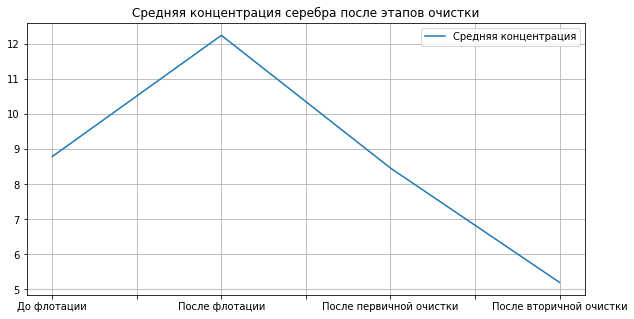

In [ ]:
ag_mean.plot(figsize=(10, 5), 
    title='Средняя концентрация серебра после этапов очистки', grid=True)

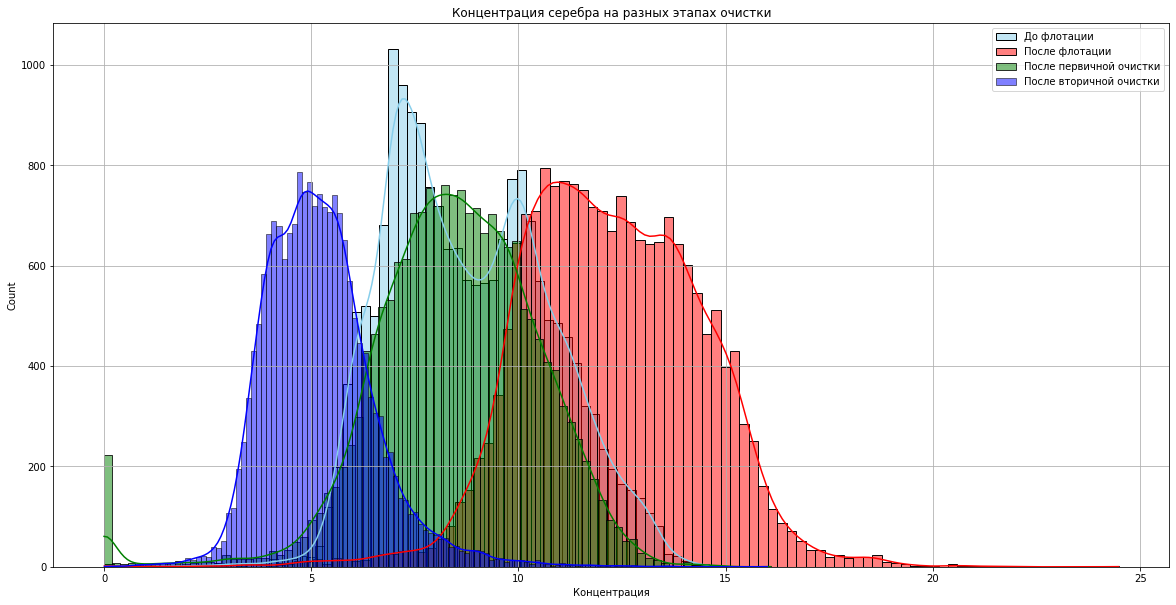

In [ ]:
plt.figure(figsize=(20, 10))
sns.histplot(ag['rougher.input.feed_ag'], label="До флотации", color="skyblue", kde=True)
sns.histplot(ag['rougher.output.concentrate_ag'], label="После флотации", color="red", kde=True)
sns.histplot(ag['primary_cleaner.output.concentrate_ag'], label="После первичной очистки", color="green", kde=True)
sns.histplot(ag['final.output.concentrate_ag'], label="После вторичной очистки", color="blue", kde=True)
plt.legend()
plt.title('Концентрация серебра на разных этапах очистки')
plt.xlabel('Концентрация')
plt.grid(True)

Как можем заметить, концентрация серебра после флотации увеличивается в среднем на 1.1%, а на следующих этапах очистки снижается.

#### Свинец

In [ ]:
pb_mean = concentrate(pb)
pb_mean

,Средняя концентрация
До флотации,3.581617
После флотации,7.763225
После первичной очистки,9.805949
После вторичной очистки,10.034090


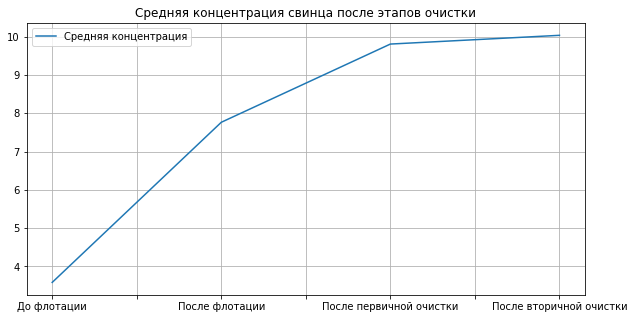

In [ ]:
pb_mean.plot(figsize=(10, 5), 
    title='Средняя концентрация свинца после этапов очистки', grid=True)

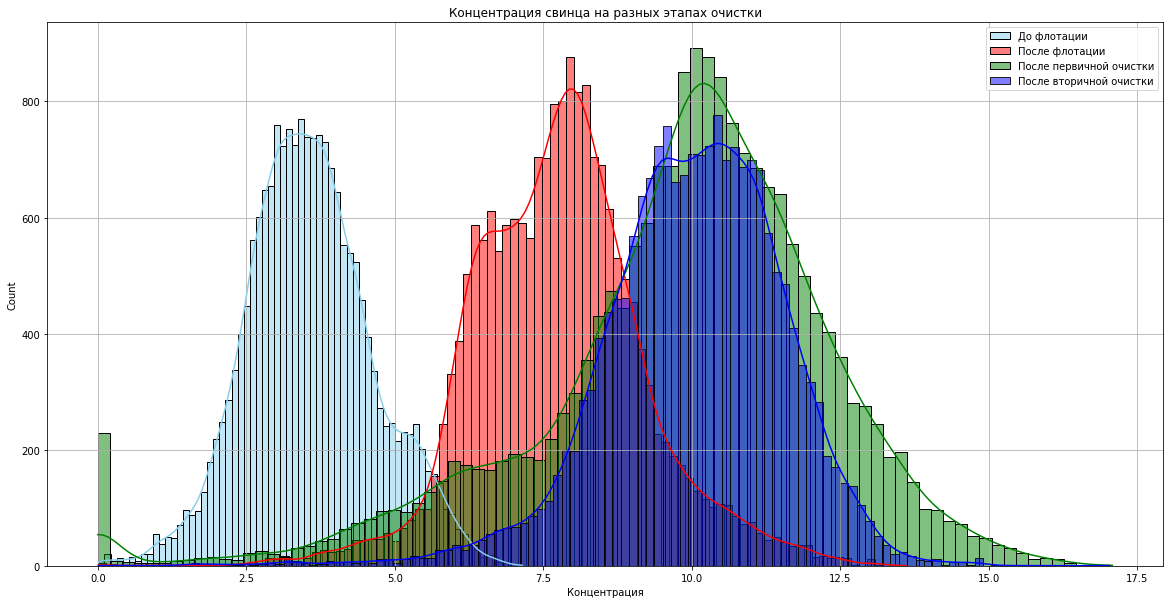

In [ ]:
plt.figure(figsize=(20, 10))
sns.histplot(pb['rougher.input.feed_pb'], label="До флотации", color="skyblue", kde=True)
sns.histplot(pb['rougher.output.concentrate_pb'], label="После флотации", color="red", kde=True)
sns.histplot(pb['primary_cleaner.output.concentrate_pb'], label="После первичной очистки", color="green", kde=True)
sns.histplot(pb['final.output.concentrate_pb'], label="После вторичной очистки", color="blue", kde=True)
plt.legend()
plt.title('Концентрация свинца на разных этапах очистки')
plt.xlabel('Концентрация')
plt.grid(True)

Доля свинца в продукте на каждом этапе очистки существенно растет, кроме второго этапа очистки, при котором доля свинца увеличивается в среднем всего на 0.11%.

#### Золото

In [ ]:
au_mean = concentrate(au)
au_mean

,Средняя концентрация
До флотации,8.258139
После флотации,20.177817
После первичной очистки,32.101133
После вторичной очистки,44.280284


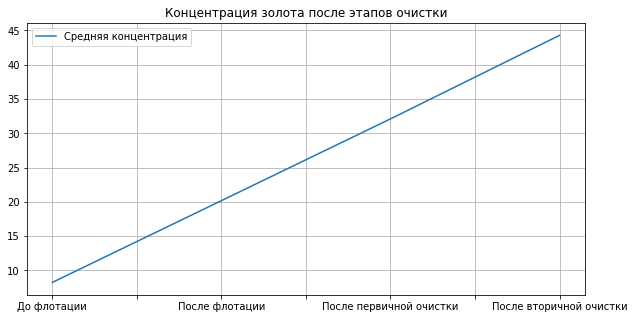

In [ ]:
au_mean.plot(figsize=(10, 5), 
    title='Концентрация золота после этапов очистки', grid=True)

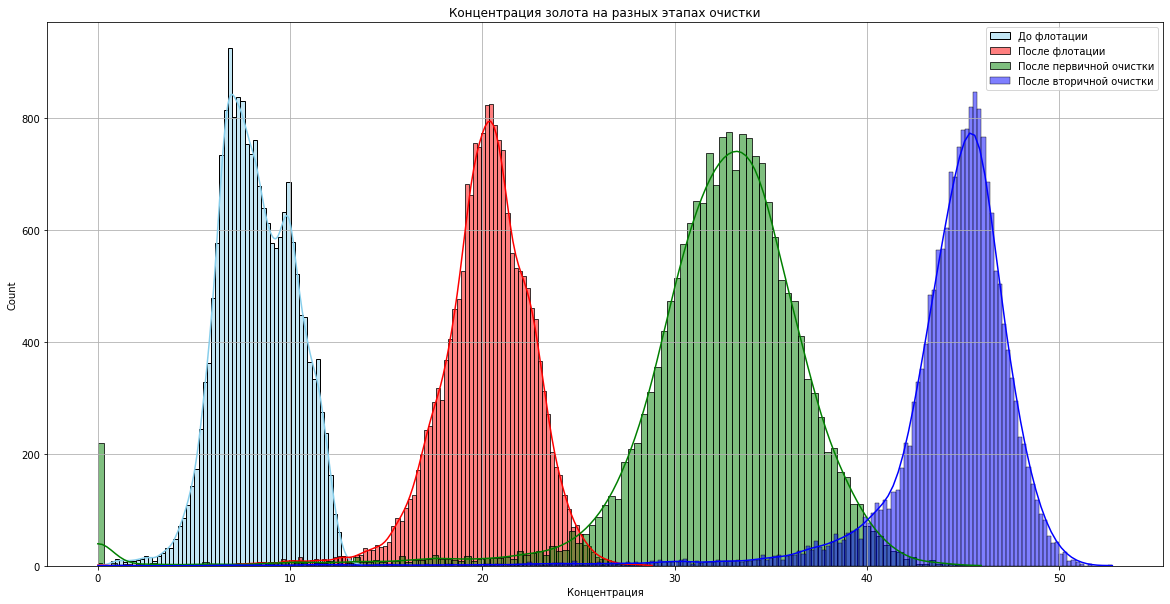

In [ ]:
plt.figure(figsize=(20, 10))
sns.histplot(au['rougher.input.feed_au'], label="До флотации", color="skyblue", kde=True)
sns.histplot(au['rougher.output.concentrate_au'], label="После флотации", color="red", kde=True)
sns.histplot(au['primary_cleaner.output.concentrate_au'], label="После первичной очистки", color="green", kde=True)
sns.histplot(au['final.output.concentrate_au'], label="После вторичной очистки", color="blue", kde=True)
plt.legend()
plt.title('Концентрация золота на разных этапах очистки')
plt.xlabel('Концентрация')
plt.grid(True)

Концентрация  золота в продукте после каждого этапа очистки увеличивается в среднем на 12%.

Таким образом, можем сказать, что доля свинца и золота после каждого этапа очистки увеличивается, доля серебра после первичной очистки снижается.

### Сравнение распределений размеров гранул сырья на обучающей и тестовой выборках

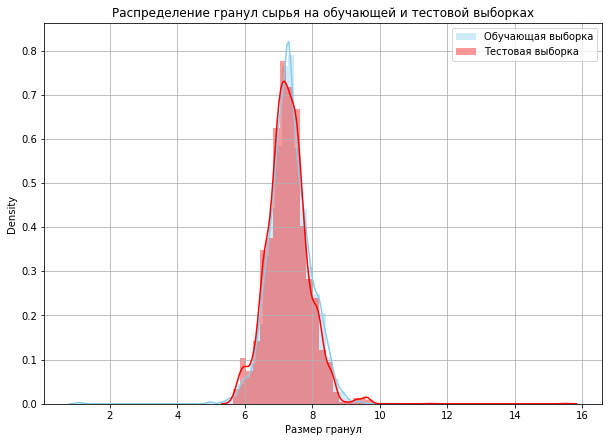

In [ ]:
plt.figure(figsize=(10, 7))
sns.distplot(df_train['primary_cleaner.input.feed_size'], label="Обучающая выборка", color="skyblue")
sns.distplot(df_test['primary_cleaner.input.feed_size'], label="Тестовая выборка", color="red")
plt.legend()
plt.title('Распределение гранул сырья на обучающей и тестовой выборках')
plt.xlabel('Размер гранул')
plt.grid(True)

Можем заметить, что распределения гранул сырья на обучающей и тестовой выборках похожи.

### Анализ суммарной концентрации веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [ ]:
data = pd.DataFrame()
data['Сырье'] = df_full['rougher.input.feed_ag'] + df_full['rougher.input.feed_pb'] + df_full['rougher.input.feed_au'] + df_full['rougher.input.feed_sol']
data['Черновой концентрат'] = df_full['rougher.output.concentrate_ag'] + df_full['rougher.output.concentrate_pb'] + df_full['rougher.output.concentrate_au'] + df_full['rougher.output.concentrate_sol']
data['Финальный концентрат'] = df_full['final.output.concentrate_ag'] + df_full['final.output.concentrate_pb'] + df_full['final.output.concentrate_au'] + df_full['final.output.concentrate_sol']
data.mean()

Сырье                   57.328171
Черновой концентрат     69.571825
Финальный концентрат    69.000211
dtype: float64

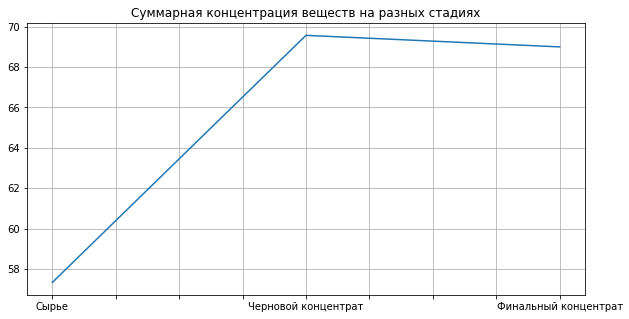

In [ ]:
data.mean().plot(figsize=(10, 5), 
    title='Суммарная концентрация веществ на разных стадиях', grid=True)

No handles with labels found to put in legend.


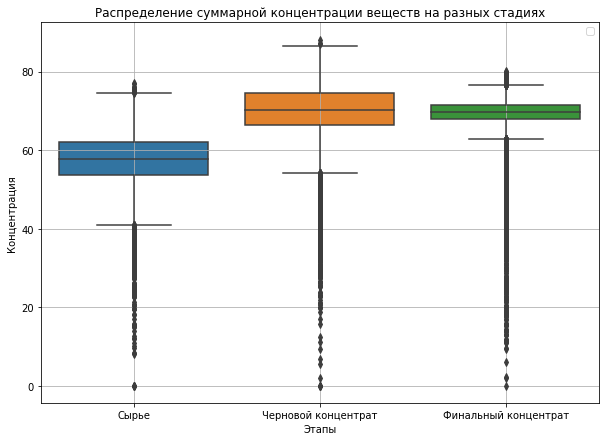

In [ ]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="variable", y="value", data=pd.melt(data))
plt.legend()
plt.title('Распределение суммарной концентрации веществ на разных стадиях')
plt.ylabel('Концентрация')
plt.xlabel('Этапы')
plt.grid(True)

Средняя концентрация веществ на разных стадиях увеличивается: 


1.   в сырье 57.32% веществ
2.   в черновом концентрате 68.17% веществ
3.   в ыинальном концентрате 68.65% веществ



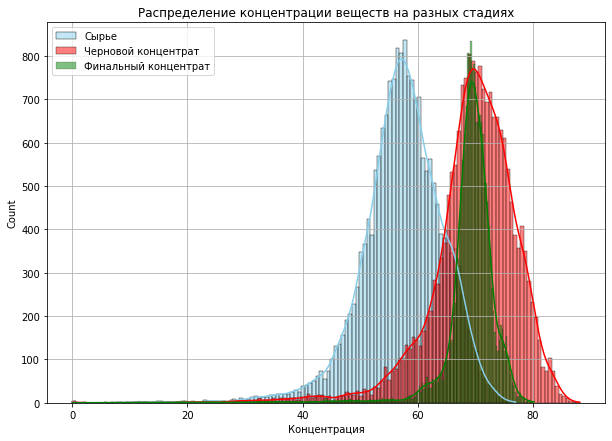

In [ ]:
plt.figure(figsize=(10, 7))
sns.histplot(data['Сырье'], label="Сырье", color="skyblue", kde=True)
sns.histplot(data['Черновой концентрат'], label="Черновой концентрат", color="red", kde=True)
sns.histplot(data['Финальный концентрат'], label="Финальный концентрат", color="green", kde=True)
plt.legend()
plt.title('Распределение концентрации веществ на разных стадиях')
plt.xlabel('Концентрация')
plt.grid(True)

(0.0, 100.0)

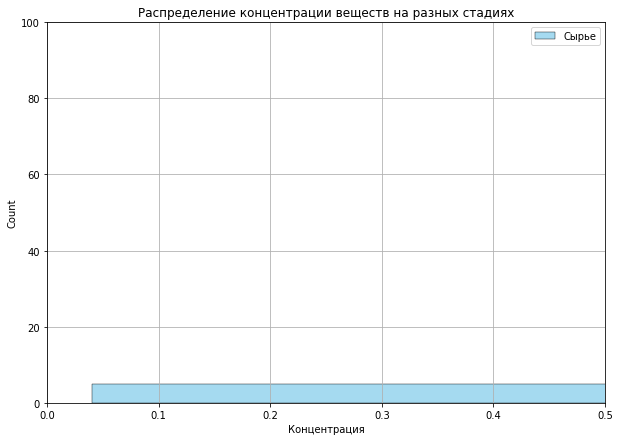

In [ ]:
plt.figure(figsize=(10, 7))
sns.histplot(data['Сырье'], label="Сырье", color="skyblue")
plt.legend()
plt.title('Распределение концентрации веществ на разных стадиях')
plt.xlabel('Концентрация')
plt.grid(True)
plt.xlim(0, 0.5)
plt.ylim(0, 100)


Кроме того, можем заметить наличие аномальных значений (выбросов). Удалять их из всех этапов не будем, так как в дальнейшем анализе при построении моделей эти признаки будут удалены, ввиду отсутствия в тестовой выборке. Однако признаки, отражающие стадию сырья, в тестовой выборке присутсвуют, поэтому в них стоит избавиться от аномальных значений, близких к нулю.

In [ ]:
df_train = df_train[(
    df_train['rougher.input.feed_au'] + 
    df_train['rougher.input.feed_ag'] + 
    df_train['rougher.input.feed_pb'] + 
    df_train['rougher.input.feed_sol'])>0.1]

In [ ]:
df_test = df_test[(
    df_test['rougher.input.feed_au'] + 
    df_test['rougher.input.feed_ag'] + 
    df_test['rougher.input.feed_pb'] + 
    df_test['rougher.input.feed_sol'])>0.1]

## Модель

In [ ]:
def smape(target, predict):
  smape = (1 / len(target)) * 100 * ((abs(target-predict)) / ((abs(target+predict))/2)).sum()
  return smape

In [ ]:
def smape_full(smape_rougher, smape_final):
    result = (0.25 * smape_rougher) + (0.75 * smape_final)
    return result

Функции для вычисления sMAPE и итоговой sMAPE (Symmetric Mean Absolute Percentage Error).

Удалим из обучающей выборки данные, остутствующие в тестовой выборке.

In [ ]:
df_train = df_train.drop(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.tail_ag',
       'rougher.output.tail_au', 'rougher.output.tail_pb',
       'rougher.output.tail_sol', 'secondary_cleaner.output.tail_ag',
       'secondary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_pb',
       'secondary_cleaner.output.tail_sol', 'date'], axis=1)
df_test = df_test.drop(['date'], axis=1)

Разделим обучающую выборку на признаки и целевые признаки, при этом отделим признаки, необходимые для прогноза после этапа флотации (возьмем все данные до флотации) и признаки для прогноза финального этапа (данные после флотации).

In [ ]:
rougher_columns = list(filter(lambda x: 'rougher' in x, df_test.columns.tolist()))
final_columns = list(set(df_test.columns)-set(rougher_columns))
features_rough_train = df_train[rougher_columns]
features_final_train = df_train[final_columns]
target_rough_train = df_train['rougher.output.recovery']
target_final_train = df_train['final.output.recovery']

В тестовом наборе данных отсутствуют целевые признаки `rougher.output.recovery` и `final.output.recovery`, но в исходной выборке (df_full) они присутствуют, поэтому мы присоединим их к тестовой выборке, а затем выделим в целевые признаки.

In [ ]:
features_rough_test = df_test.loc[df_test.index.intersection(df_full.index), rougher_columns]
features_final_test = df_test.loc[df_test.index.intersection(df_full.index), final_columns]
target_rough_test = df_full.loc[df_test.index.intersection(df_full.index), 'rougher.output.recovery']
target_final_test = df_full.loc[df_test.index.intersection(df_full.index), 'final.output.recovery']

Масштабируем данные.  
Некоторые модели чувствительны к значениям, поэтому необходимо произвести масштабирование. 

In [ ]:
scaler = StandardScaler()
features_final_train = scaler.fit_transform(features_final_train)
features_final_test = scaler.transform(features_final_test)
features_rough_train = scaler.fit_transform(features_rough_train)
features_rough_test = scaler.transform(features_rough_test)

Выборки разделены, можем приступать к обучению. Качество разных моделей будем оценивать кросс-валидацией.

In [ ]:
scorer = make_scorer(smape, greater_is_better=False)

Подготовили метрику для оценки моделей.

Создадим функцию для подбора гипермараметров с помощью GridSearch.

In [ ]:
def grid (model, parameters, features_train, target_train):
  grid = GridSearchCV(model,parameters, scoring=scorer, cv=5, return_train_score=False)
  grid.fit(features_train, target_train)
  return -grid.best_score_, grid.best_params_

Создадим функцию для добавления результатов работы моделей.

In [ ]:
results_rougher = {'name': [], 'best_params':[], 'cv_smape':[]}
results_final = {'name': [], 'best_params':[], 'cv_smape':[]}

def add_model_result(results, name, best_params, smape):
    results['name'].append(name)
    results['best_params'].append(best_params)
    results['cv_smape'].append(smape)

### Линейная регрессия 

In [ ]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 
              'normalize':[True,False], 
              'copy_X':[True, False]}

In [ ]:
print('sMAPE и лучшие параметры для целевого признака rougher.output.recovery:', grid(model, parameters, features_rough_test, target_rough_test))
print('sMAPE и лучшие параметры для целевого признака final.output.recovery:', grid(model, parameters, features_final_test, target_final_test))

sMAPE и лучшие параметры для целевого признака rougher.output.recovery: (7.769183170089221, {'copy_X': True, 'fit_intercept': True, 'normalize': False})
sMAPE и лучшие параметры для целевого признака final.output.recovery: (11.323509256570627, {'copy_X': True, 'fit_intercept': True, 'normalize': False})


Модель - линейная регрессия, показала следующие результаты:


*   Для целевого признака `rougher.output.recovery` sMAPE = 7.77%
*   Для целевого признака `final.output.recovery` sMAPE = 11.32%



In [ ]:
add_model_result(results_rougher, 'LinearRegression', grid(model, parameters, features_rough_test, target_rough_test)[1], grid(model, parameters, features_rough_test, target_rough_test)[0])
add_model_result(results_final, 'LinearRegression', grid(model, parameters, features_final_test, target_final_test)[1], grid(model, parameters, features_final_test, target_final_test)[0])


### Ridge

In [ ]:
model = Ridge()
parameters = {'alpha':[10,15,25,30,50,100,150,200,500,600,700,750,785,790,800,900,1000,1001]}

In [ ]:
print('sMAPE и лучшие параметры для целевого признака rougher.output.recovery:', grid(model, parameters, features_rough_test, target_rough_test))
print('sMAPE и лучшие параметры для целевого признака final.output.recovery:', grid(model, parameters, features_final_test, target_final_test))

sMAPE и лучшие параметры для целевого признака rougher.output.recovery: (7.491874895642797, {'alpha': 900})
sMAPE и лучшие параметры для целевого признака final.output.recovery: (10.28880461060646, {'alpha': 1001})


Модель - Ridge, показала следующие результаты:


*   Для целевого признака `rougher.output.recovery` sMAPE = 7.49%
*   Для целевого признака `final.output.recovery` sMAPE = 10.28%


In [ ]:
add_model_result(results_rougher, 'Ridge', grid(model, parameters, features_rough_test, target_rough_test)[1], grid(model, parameters, features_rough_test, target_rough_test)[0])
add_model_result(results_final, 'Ridge', grid(model, parameters, features_final_test, target_final_test)[1], grid(model, parameters, features_final_test, target_final_test)[0])

### Lasso

In [ ]:
model = Lasso()
parameters = {'alpha':[0.0005,0.0006,0.06,0.5,0.0001,0.01,1,2,3,4,4.4,4]}

In [ ]:
print('sMAPE и лучшие параметры для целевого признака rougher.output.recovery:', grid(model, parameters, features_rough_test, target_rough_test))
print('sMAPE и лучшие параметры для целевого признака final.output.recovery:', grid(model, parameters, features_final_test, target_final_test))

sMAPE и лучшие параметры для целевого признака rougher.output.recovery: (7.545111414194679, {'alpha': 0.06})
sMAPE и лучшие параметры для целевого признака final.output.recovery: (10.025060657940525, {'alpha': 4})


Модель - Lasso, показала следующие результаты:


*   Для целевого признака `rougher.output.recovery` sMAPE = 7.55%
*   Для целевого признака `final.output.recovery` sMAPE = 10.02%


In [ ]:
add_model_result(results_rougher, 'Lasso', grid(model, parameters, features_rough_test, target_rough_test)[1], grid(model, parameters, features_rough_test, target_rough_test)[0])
add_model_result(results_final, 'Lasso', grid(model, parameters, features_final_test, target_final_test)[1], grid(model, parameters, features_final_test, target_final_test)[0])

### ElasticNet

In [ ]:
model = ElasticNet()
parameters = {'max_iter': [1, 5, 10], 
              'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              'l1_ratio': np.arange(0.0, 1.0, 0.1)}

In [ ]:
print('sMAPE и лучшие параметры для целевого признака rougher.output.recovery:', grid(model, parameters, features_rough_test, target_rough_test))
print('sMAPE и лучшие параметры для целевого признака final.output.recovery:', grid(model, parameters, features_final_test, target_final_test))

sMAPE и лучшие параметры для целевого признака rougher.output.recovery: (7.4695900385383185, {'alpha': 0.1, 'l1_ratio': 0.7000000000000001, 'max_iter': 5})
sMAPE и лучшие параметры для целевого признака final.output.recovery: (10.024161987023271, {'alpha': 100, 'l1_ratio': 0.0, 'max_iter': 5})


Модель - ElasticNet, показала следующие результаты:


*   Для целевого признака `rougher.output.recovery` sMAPE = 7.47%
*   Для целевого признака `final.output.recovery` sMAPE = 10.02%


In [ ]:
add_model_result(results_rougher, 'ElasticNet', grid(model, parameters, features_rough_test, target_rough_test)[1], grid(model, parameters, features_rough_test, target_rough_test)[0])
add_model_result(results_final, 'ElasticNet', grid(model, parameters, features_final_test, target_final_test)[1], grid(model, parameters, features_final_test, target_final_test)[0])

### RandomForestRegressor

In [ ]:
def objective(trial):
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 31),
            'max_depth': trial.suggest_int('max_depth', 4, 14),
            'min_samples_split': trial.suggest_int('min_samples_split', 1, 5),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    }
    
    model = RandomForestRegressor(random_state=12345, **params)
    score = cross_val_score(model, features_rough_test, target_rough_test, scoring=scorer, cv=5).mean()
    return score

In [ ]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 50)
trial = study.best_trial

In [ ]:
print("Best Score: ", -trial.value)
print("Best Params: ", study.best_params)

Best Score:  8.606715329562213
Best Params:  {'n_estimators': 27, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}


Модель RandomForestRegressor для целевого признака `rougher.output.recovery` показала sMAPE = 8.6%.

In [ ]:
add_model_result(results_rougher, 'RandomForestRegressor', study.best_params, -trial.value)

In [ ]:
def objective(trial):
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 31),
            'max_depth': trial.suggest_int('max_depth', 4, 14),
            'min_samples_split': trial.suggest_int('min_samples_split', 1, 5),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    }
    
    model = RandomForestRegressor(random_state=12345, **params)
    
    score = cross_val_score(model, features_final_test, target_final_test, scoring=scorer, cv=5).mean()
    return score

In [ ]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 50)
trial = study.best_trial

In [ ]:
print("Best Score: ", -trial.value)
print("Best Params: ", study.best_params)

Best Score:  11.223937302055988
Best Params:  {'n_estimators': 29, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}


Для целевого признака `final.output.recovery` модель RandomForestRegressor показала sMAPE = 11.23%.

In [ ]:
add_model_result(results_final, 'RandomForestRegressor', study.best_params, -trial.value)

### CatBoostRegressor

*Обучался очень долго, поэтому количество итераций сокращено, и установлен таймер окончания*

In [ ]:
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth',1, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 3, 5, 7),
        'learning_rate' : 0.01,
        'iterations': 1000,
        'loss_function' : 'MAE',
        'early_stopping_rounds' : 50,
        'random_seed' : 92,
        'leaf_estimation_method' : 'Gradient',
        'bootstrap_type' : 'Bernoulli',
        'silent' : True
    }

    model = CatBoostRegressor( **params)
    score = cross_val_score(model, features_rough_test, target_rough_test, scoring=scorer, cv=5).mean()
    return score

In [ ]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 20, timeout=200)
trial = study.best_trial

In [ ]:
print("Best Score: ", -trial.value)
print("Best Params: ", study.best_params)

Best Score:  7.835227043424311
Best Params:  {'depth': 4, 'l2_leaf_reg': 3}


Модель CatBoostRegressor для целевого признака `rougher.output.recovery` показала sMAPE = 7.83%.

In [ ]:
add_model_result(results_rougher, 'CatBoostRegressor', study.best_params, -trial.value)


In [ ]:
def objective(trial):
  
  params = {
        'depth': trial.suggest_int('depth',1, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 3, 5, 7),
        'learning_rate' : 0.01,
        'iterations': 1000,
        'loss_function' : 'MAE',
        'early_stopping_rounds' : 50,
        'random_seed' : 92,
         'leaf_estimation_method' : 'Gradient',
        'bootstrap_type' : 'Bernoulli',
        'silent' : True
    }

  model = CatBoostRegressor(**params)
  score = cross_val_score(model, features_final_test, target_final_test, scoring=scorer, cv=5).mean()
  return score

In [ ]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 20, timeout=400)
trial = study.best_trial

In [ ]:
print("Best Score: ", -trial.value)
print("Best Params: ", study.best_params)

Best Score:  9.845258077634641
Best Params:  {'depth': 2, 'l2_leaf_reg': 3}


Модель CatBoostRegressor для целевого признака `final.output.recovery` показала sMAPE = 9.85%.

In [ ]:
add_model_result(results_final, 'CatBoostRegressor', study.best_params, -trial.value)


In [ ]:
pd.DataFrame(results_rougher).sort_values('cv_smape')


,name,best_params,cv_smape
3,ElasticNet,"{'alpha': 0.1, 'l1_ratio': 0.7000000000000001,...",7.469590
1,Ridge,{'alpha': 900},7.491875
2,Lasso,{'alpha': 0.06},7.545111
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'norma...",7.769183
5,CatBoostRegressor,"{'depth': 4, 'l2_leaf_reg': 3}",7.835227
4,RandomForestRegressor,"{'n_estimators': 27, 'max_depth': 4, 'min_samp...",8.606715


In [ ]:
pd.DataFrame(results_final).sort_values('cv_smape')

,name,best_params,cv_smape
5,CatBoostRegressor,"{'depth': 2, 'l2_leaf_reg': 3}",9.845258
3,ElasticNet,"{'alpha': 100, 'l1_ratio': 0.0, 'max_iter': 5}",10.024162
2,Lasso,{'alpha': 4},10.025061
1,Ridge,{'alpha': 1001},10.288805
4,RandomForestRegressor,"{'n_estimators': 29, 'max_depth': 5, 'min_samp...",11.223937
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'norma...",11.323509


Таким образом, лучшей моделью является ElasticNet.

## Проверка модели на тестовой выборке

In [ ]:
model_rough = ElasticNet(alpha = 0.1, l1_ratio = 0.7, max_iter = 5)
model_final = ElasticNet(alpha = 100, l1_ratio = 0.0, max_iter = 5)
model_rough.fit(features_rough_train, target_rough_train)
model_final.fit(features_final_train, target_final_train)
predicted_rough_test = model_rough.predict(features_rough_test)
predicted_final_test = model_final.predict(features_final_test)
smape_rougher = smape(target_rough_test, predicted_rough_test)
smape_final = smape(target_final_test, predicted_final_test)

In [ ]:
print('sMAPE:', smape_full(smape_rougher, smape_final))

sMAPE: 9.809711017396655


Итоговый Smape на тестовой выборке составил 9.8%.

### Сравнение с DummyRegressor

In [ ]:
model_rough = DummyRegressor()
model_final = DummyRegressor()
model_rough.fit(features_rough_train, target_rough_train)
model_final.fit(features_final_train, target_final_train)
predicted_rough_test = model_rough.predict(features_rough_test)
predicted_final_test = model_final.predict(features_final_test)
smape_rougher = smape(target_rough_test, predicted_rough_test)
smape_final = smape(target_final_test, predicted_final_test)

In [ ]:
print('sMAPE:', smape_full(smape_rougher, smape_final))

sMAPE: 9.598007253042802


Константная модель DummyRegressor предсказала итоговый sMAPE 9.6%, что на 0.2% меньше нашей модели. Однако стоит упомянуть, что при обучении моделей, мы перебирали малое число гиперпараметров (в целях экономии времени), поэтому можем сказать, что наша модель предсказывает также, как и случайная.

Для улучшения целевой метрики необходимо улучшить саму модель (расширить подобор гиперпараметров или использовать другие модели машинного обучения).


## Вывод

Таким образом, нами проведен анализ и подготовка данных, проверены 6 моделей, для каждой определено значение sMAPE и выбраны модели с лучшими показателями.
Лучшей моделю выбрана ElasticNet. К сожалению, наша модель по качеству оказалась на уровне констатной модели, поэтому были предложены варианты ее улучшения.